# Linear and Logistic regression assignment

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import confusion_matrix
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

## Business Understanding

The goal of this assignment is to explore and apply linear and logistic regression models to a real-world dataset. Linear regression is used to model and predict continuous values, while logistic regression is applied to a classification task derived from the same dataset. The objective is to understand how these models work, how they are trained and how their perfomance can be evaluated using appropriate metrics.

The objectives of this assignment are:

- to learn to use linear regression for predicting continuously varying target variables
- to learn to use logistic regression for binary classification
- to learn to estimate the relative importance of input features


## Data understanding

We start by fetching the dataset and printing out the first few rows

In [9]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)
# data (as pandas dataframes)
data = real_estate_valuation.data.original
data = data.drop(columns=['No'])

data.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


This dataset clearly contains information/measurements about various houses and their corresponding market values.

The features in the dataset are as follows:
- 'No': A unique identifier for each house (we will not use this feature in modeling)
- 'X1 transaction date': The transaction date (for example, 2013.250 = March 2013)
- 'X2 house age': The age of the house (in years)
- 'X3 distance to the nearest MRT station': The distance to the nearest MRT (Mass Rapid Transit) station
- 'X4 number of convenience stores': The number of convenience stores in the vicinity
- 'X5 latitude': The latitude coordinate of the house location
- 'X6 longitude': The longitude coordinate of the house location
- 'Y house price of unit area': The market price of the house per unit area

Our clear target variable is 'Y house price of unit area', which we will try to predict using the other features in the dataset.

In [10]:
data.describe()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


After studying the basic statistics of the dataset we can see that the average house price per unit area is around 37.98. Something else that could be interesting to note is that the average age of the houses in the dataset is around 17.7 years, and the average distance to the nearest MRT station is around 1083 (presumably in meters). The number of convenience stores in the vicinity varies from 0 to 10, with an average of around 4.1 stores.

Next we wanna see how the different features correlate with the target variable (house price of unit area). We are looking for values that are close to 1 or -1 as they indicate strong positive or negative correlation respectively.

In [11]:
# Calculate the correlation matrix
correlation_matrix = data.corr()
# Display the correlation of each feature with the target variable
target_correlation = correlation_matrix['Y house price of unit area'].sort_values(ascending=False)
print(target_correlation)

Y house price of unit area                1.000000
X4 number of convenience stores           0.571005
X5 latitude                               0.546307
X6 longitude                              0.523287
X1 transaction date                       0.087491
X2 house age                             -0.210567
X3 distance to the nearest MRT station   -0.673613
Name: Y house price of unit area, dtype: float64


When we are looking at the features and their correlations with the target variable, we can also visualize the relationships using scatter plots. This can help us to see if there are any patterns or trends in the data. Lets create a scatter plot for each feature against the target variable 'Y house price of unit area'.

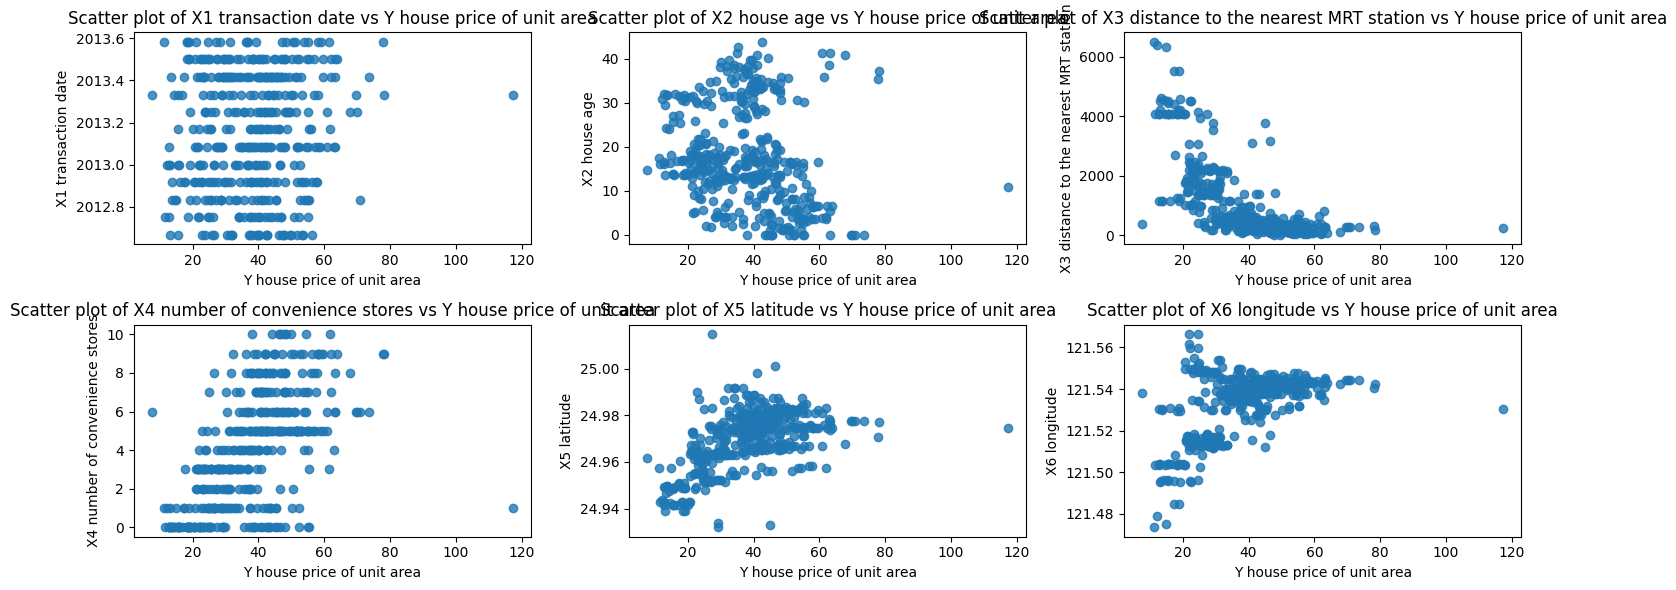

In [12]:
# Creating scatter plots for each feature against the target variable where the feature is on the y-axis and the target variable is on the x-axis
features = data.columns.drop('Y house price of unit area')
target = 'Y house price of unit area'
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()
for i, feature in enumerate(features):
    ax = axes[i]
    ax.scatter(data[target], data[feature], alpha=0.8)
    ax.set_xlabel('Y house price of unit area')
    ax.set_ylabel(feature)
    ax.set_title(f'Scatter plot of {feature} vs {target}')
plt.tight_layout()
plt.show()

From the visual scatter plots we can immediately see that it's much harder to identify clear linear relationships between the features and the target variable compared to the correlation numbers we saw earlier. However, we can still observe some trends:
- Both latitude and longitude seem to have some kind of relationship with the house price per unit area. This makes sense as the location of a house often affects the price.
- While hard to see, there is a slight positive trend between the number of convenience stores and the house price per unit area, which aligns with the positive correlation we observed earlier.

## Data preparation

Before we start to go through the data we can make a statement that this dataset does not contain any missing values. In the upcoming modeling phase we are going to build linear and logistic regression models. For linear regression we can just split the data and scale it, but since logistic regression is a classification model, we will need to create a new target variable that classifies the houses into two categories based on whether their price per unit area is above or below the average price in the dataset.

In [19]:
# The average price per unit area
average_price = data['Y house price of unit area'].mean()
# Adding a new column 'Price Category' to classify houses as above average (1) or below average (0) based on the 'Y house price of unit area'
data['Price Category'] = data['Y house price of unit area'].apply(lambda x: 1 if x > average_price else 0)

# Splitting the dataset to inputs (X) and targets (y)
X = data.drop(columns=['Y house price of unit area', 'Price Category'])  # inputs
y = data[['Y house price of unit area', 'Price Category']]  # targets for both linear and logistic regression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Separating the target variable for linear regression and logistic regression
linear_y_train = y_train['Y house price of unit area']
linear_y_test = y_test['Y house price of unit area']

logistic_y_train = y_train['Price Category']
logistic_y_test = y_test['Price Category']

# Standardize the features using StandardScaler
scaler = StandardScaler()

# Using fit_transform on the training data to compute the mean and standard deviation.
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Using transform on the test data to apply the same scaling as was computed on the training data.
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_train.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
0,-0.244072,-0.359605,-0.738402,1.016920,-0.166495,0.576185
1,-1.127500,-0.613455,1.584306,-1.392286,-1.184515,2.120780
2,-1.127500,1.522385,-0.475261,0.328575,0.403274,0.323197
3,1.522785,-0.079495,0.445225,-0.703942,-1.237629,1.175813
4,-1.714097,-0.149523,-0.628657,0.328575,1.022938,0.638620


## Modeling

For the modeling phase we will create two models: a linear regression model and a logistic regression model. The linear regression model will be used to predict the house price per unit area, while the logistic regression model will be used to classify the houses into two categories based on whether their price per unit area is above or below the average. We will start with the linear regression model.

### Linear Regression Modeling

We use Linear regression, to model the relationship between the explanatory variables and the house price. We train model to use training data and evaluate the test data. Model will measure performance using "Mean Absolute Error" (MAE), which represent the average absolute difference between predicted and actual house prices.

We can visualise the linear model by scattering the values from each column and drawing a lines between the Intercept and Coefficient values


Overall Model Intercept: 38.10
Overall Model Coefficients:
  X1 transaction date: 1.4483
  X2 house age: -3.1680
  X3 distance to the nearest MRT station: -5.8851
  X4 number of convenience stores: 3.1130
  X5 latitude: 2.6301
  X6 longitude: -0.4351

X1 transaction date:
  Intercept: 38.10, Coefficient: 1.4483


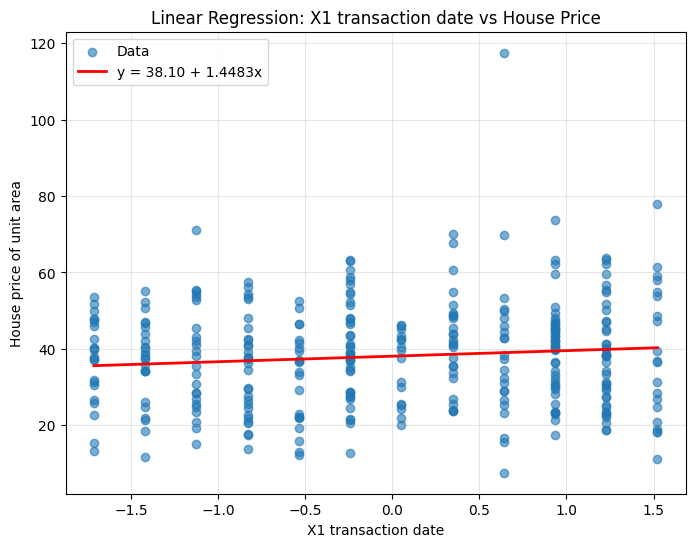


X2 house age:
  Intercept: 38.10, Coefficient: -3.1680


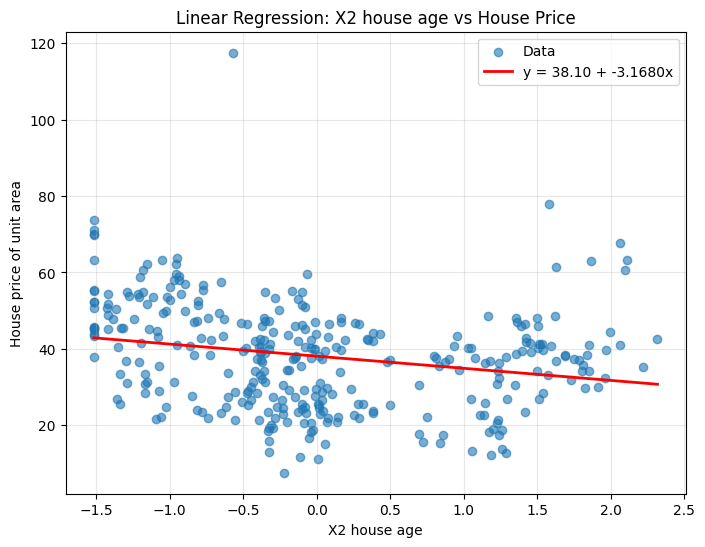


X3 distance to the nearest MRT station:
  Intercept: 38.10, Coefficient: -5.8851


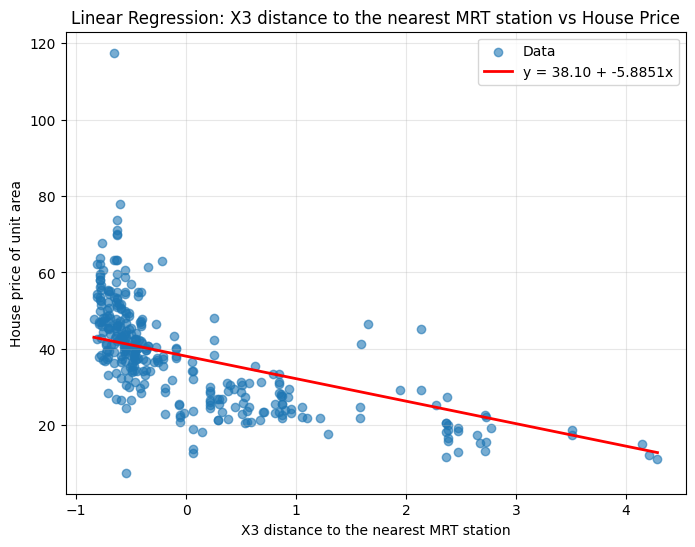


X4 number of convenience stores:
  Intercept: 38.10, Coefficient: 3.1130


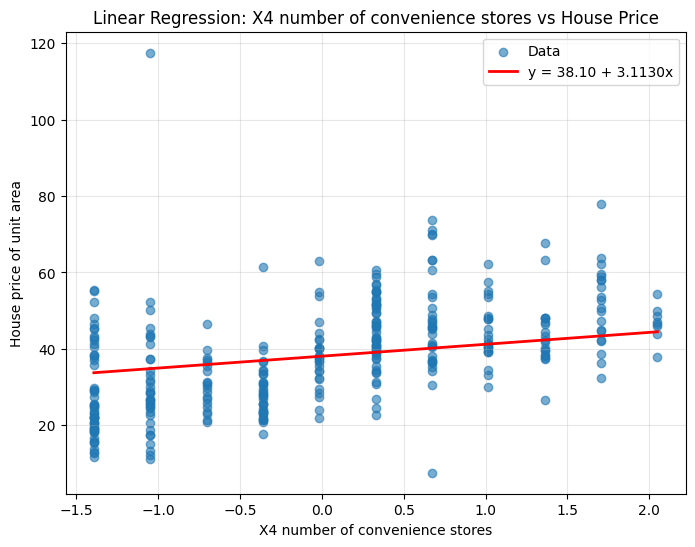


X5 latitude:
  Intercept: 38.10, Coefficient: 2.6301


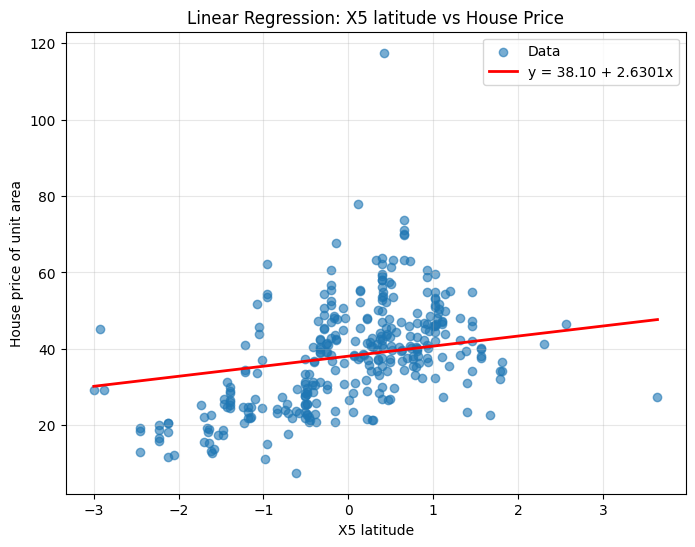


X6 longitude:
  Intercept: 38.10, Coefficient: -0.4351


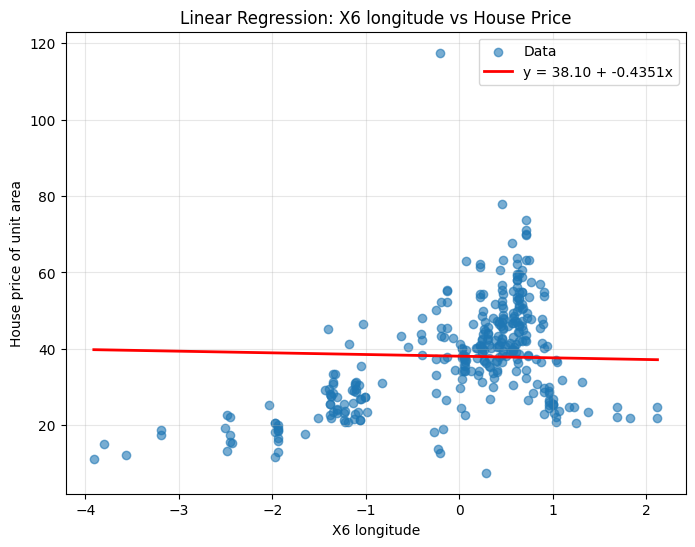

In [22]:
linear_model = LinearRegression()
linear_model.fit(X_train, linear_y_train)

# Print overall model parameters
print(f"\nOverall Model Intercept: {linear_model.intercept_:.2f}")
print("Overall Model Coefficients:")
for col, coef in zip(X_train.columns, linear_model.coef_):
    print(f"  {col}: {coef:.4f}")

for i, column in enumerate(X_train.columns):
    X_single = X_train[[column]] 
    
    # Get parameters for this specific feature
    b0 = linear_model.intercept_
    b1 = linear_model.coef_[i]
    
    # Create line for this feature
    xs = np.linspace(X_train[column].min(), X_train[column].max(), 100)
    ys = b0 + b1 * xs
    
    # Print parameters
    print(f"\n{column}:")
    print(f"  Intercept: {b0:.2f}, Coefficient: {b1:.4f}")
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train[column], linear_y_train, alpha=0.6, label='Data')
    plt.plot(xs, ys, 'r-', linewidth=2, label=f'y = {b0:.2f} + {b1:.4f}x')
    plt.xlabel(column)
    plt.ylabel('House price of unit area')
    plt.title(f'Linear Regression: {column} vs House Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

### Logistic Regression Modeling

Here we build and train the logistic regression model. For the logistic regression model, we chose to use the standard 'lbfgs' solver to find the best weights.

In [29]:
# Building and fitting the logistic regression model
logistic_model = LogisticRegression(solver='lbfgs')
logistic_model.fit(X_train, logistic_y_train)

LogisticRegression()

## Evaluation

### Linear Regression Model

When evaluating the performance of the linear regression model it doesn't make sense to use accuracy or confusion matrix as those are used for classification problems. Instead we can use the Mean Absolute Error (MAE) which is the average of the absolute differences between the predicted values and the actual values. A lower MAE indicates a better fit of the model to the data.

In [30]:
y_test_pred = linear_model.predict(X_test)
print("Mean absolute error: %.2f" % mean_absolute_error(linear_y_test, y_test_pred))

Mean absolute error: 4.96


### Logistic Regression Model

For the logistic regression model we can absolutely use accuracy and confusion matrix to evaluate the performance. Accuracy will give us the overall percentage of correct predictions, while the confusion matrix will show us the breakdown of true positives, true negatives, false positives, and false negatives. We will also output the intercept value and each Coefficient value for each column on the logistic test set. Lets first print out a classification report.

In [31]:
logistic_predictions = logistic_model.predict(X_test)
print("Classification Report for Logistic Regression:")
print(classification_report(logistic_y_test, logistic_predictions, target_names=['Below Average', 'Above Average']))

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

Below Average       0.84      0.79      0.82        39
Above Average       0.83      0.86      0.84        44

     accuracy                           0.83        83
    macro avg       0.83      0.83      0.83        83
 weighted avg       0.83      0.83      0.83        83



Here we output the previously mentioned Intercept and Coefficient values while also creating the confusion matrix to visualise the accuracy of the model.

Intercept: -0.5901

Coefficients:
  X1 transaction date: 0.3641
  X2 house age: -0.6721
  X3 distance to the nearest MRT station: -2.1920
  X4 number of convenience stores: 0.6175
  X5 latitude: 0.9220
  X6 longitude: 0.1416


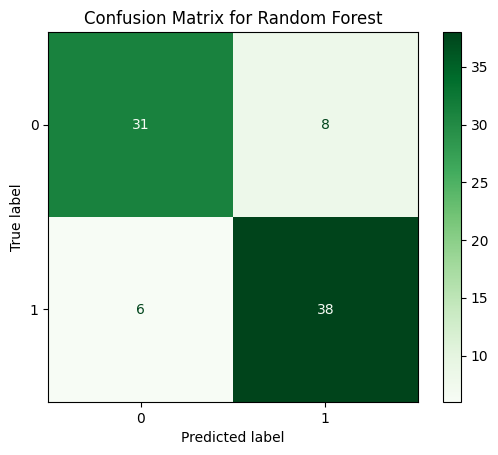


Classification Report (Test Set):
               precision    recall  f1-score   support

Below Average       0.84      0.79      0.82        39
Above Average       0.83      0.86      0.84        44

     accuracy                           0.83        83
    macro avg       0.83      0.83      0.83        83
 weighted avg       0.83      0.83      0.83        83



In [40]:
print(f"Intercept: {logistic_model.intercept_[0]:.4f}")
print("\nCoefficients:")

for feature, coef in zip(X.columns, logistic_model.coef_[0]):
    print(f"  {feature}: {coef:.4f}")

cm = confusion_matrix(logistic_y_test, logistic_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix for Random Forest")

plt.show()

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(logistic_y_test, logistic_predictions, 
                          target_names=['Below Average', 'Above Average']))

As predicted in the data understanding section, the amount of markets and the distance to the nearest MRT station significantly affect the housing unit price. It's also noteworthy that the latitude effects the housing unit price more than the longitude.

## Deployment

In [44]:
features = X_test.columns.tolist()

Xi = pd.DataFrame(columns=features)

for f in features:
    val = input(f"Enter value for feature {f}: ")
    Xi[f] = [float(val)]

Xi_scaled = pd.DataFrame(scaler.transform(Xi), columns=Xi.columns)

# Get BOTH probabilities
probabilities = logistic_model.predict_proba(Xi_scaled)[0]  # Get the full array
p_below = probabilities[0]  # Probability of class 0 (below average)
p_above = probabilities[1]  # Probability of class 1 (above average)

if p_below > 0.5:
    print(f"\n✓ PREDICTION: The house price is likely ABOVE average")
else:
    print(f"\n✓ PREDICTION: The house price is likely BELOW or EQUAL to average")


Probability of house price being above average: 0.00%
Probability of house price being below average: 100.00%

✓ PREDICTION: The house price is likely BELOW or EQUAL to average (confidence: 100.00%)
